# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    """ P1 - Prints the text of the message along with its label, for the first <input> examples. 
    # param num_examples: integer that indicates the number of examples to print
    # return: None
    """
    
    #iterate for the given input value
    for i in range(0,num_examples):
        #get the message and the label
        message = train_data[i]
        label = train_labels[i]
        
        #map the label to its category
        if label == 0:
            lab_type = 'alt.atheism'
        elif label == 1:
            lab_type = 'comp.graphics'
        elif label == 2:
            lab_type = 'sci.space'
        else:
            lab_type = 'talk.religion.misc'
        
        #print the messages and their labels
        print('Message ', i+1, ': ', message )
        print('\nLabel: ', label, ' & Label Category: ', lab_type)
        print('_________________________________________________________________________________________')


In [4]:
P1()

Message  1 :  Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label:  1  & Label Category:  comp.graphics
_________________________________________________________________________________________
Message  2 :  

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, ci

### Part 2:

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [5]:
def P2():
    """ P2 - Use CountVectorizer to turn the raw training text into feature vectors.
    # param: None
    # return: None
    """
    
    #a.) What is the size of the vocabulary? What is the average number of non-zero features per example? 
    # What fraction of the entries in the matrix are non-zero? 
    print('Part A')
    
    #sets countVectorizr and fits the training data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)

    #prints size and total number of non-zero features
    print('Size of Vocabulary: ', X.shape[1])
    print('Total Number of Non-Zero Features: ', X.nnz)

    #calculates the average number of non-zero features per example
    sums = X.sum(axis=1).A1
    counts = np.diff(X.indptr)
    np.seterr(divide='ignore', invalid='ignore')
    averages = sums / counts

    #prints the average number of non-zero features per example
    np.set_printoptions(precision=3, threshold=np.inf)
    print('Average Number of Non-Zero Features per Example: ', averages)

    #prints the fraction of the entries in the matrix that are non-zero
    print('Fraction of Non-Zero Entries in the Matrix: ', X.nnz, '/', (X.shape[0] * X.shape[1]))
    print('Sparsity: %.2f%%' % (100 * X.nnz /
                                 (X.shape[0] * X.shape[1])))
    
    #b.) What are the 0th and last feature strings (in alphabetical order)? 
    print('\nPart B')
    
    last_index = len(vectorizer.get_feature_names())-1
    print('First Feature String: ', vectorizer.get_feature_names()[0])
    print('Last Feature String: ',vectorizer.get_feature_names()[last_index])

    #c.) Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. 
    # Confirm the training vectors are appropriately shaped. 
    # Now what's the average number of non-zero features per example?
    print('\nPart C')
    
    #set countVectorizer with specified vocabulary
    my_vocab = ["atheism", "graphics", "space", "religion"]
    vect = CountVectorizer(vocabulary=my_vocab)

    #confirm the training vectors are appropriately shaped
    if type(train_data) == list:
        print('Training vectors are are appropriately shaped.')

    #fit to training data
    dtm = vect.fit_transform(train_data)

    #calculate average number of non-zero features per example
    sums = dtm.sum(axis=1).A1
    counts = np.diff(dtm.indptr)
    np.seterr(divide='ignore', invalid='ignore')
    averages = sums / counts

    #print average number of non-zero features per example
    np.set_printoptions(precision=3, threshold=np.inf)
    print('Updated Average Number of Non-Zero Features per Example: ', averages)
    
    #d.) Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram 
    # character features. What size vocabulary does this yield?
    print('\nPart D')
    
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    X = vectorizer.fit_transform(train_data)
    print('Updated Size of Vocabulary: ', X.shape[1])
    
    #e.) Use the "min_df" argument to prune words that appear in fewer than 10 documents. 
    # What size vocabulary does this yield?
    print('\nPart E')
    
    vectorizer = CountVectorizer(min_df = 10)
    X = vectorizer.fit_transform(train_data)
    print('Updated Size of Vocabulary: ', X.shape[1])
    
    #f.) What fraction of the words in the dev data are missing from the vocabulary? 
    print('\nPart F')
    
    #set countVectorizer for training data
    vectorizer_train = CountVectorizer()
    X_train = vectorizer_train.fit_transform(train_data)

    #set countVectorizer for dev data
    vectorizer_dev = CountVectorizer()
    X_dev = vectorizer_dev.fit_transform(dev_data)

    #print sizes for each countVectorizer
    print('Size of Train Vocabulary: ', X_train.shape[1])
    print('Size of Dev Vocabulary: ', X_dev.shape[1])

    #get the vocabularies for each countVectorizer
    x = vectorizer_train.vocabulary_
    y = vectorizer_dev.vocabulary_
    
    #print the amount of words in both vocabularies
    print('# Words in Both Training and Dev: ', len(x.keys() & y.keys()))
    
    #print the fraction of words that are in the dev data, but not in the vocabulary
    print('Fraction of Words in Dev NOT in Vocabulary: ', (X_dev.shape[1] - len(x.keys() & y.keys()))/ X_dev.shape[1])
    

In [6]:
P2()

Part A
Size of Vocabulary:  26879
Total Number of Non-Zero Features:  196700
Average Number of Non-Zero Features per Example:  [1.5   1.085 1.158 1.609 1.061 1.383 1.275 1.394 1.179 1.286 1.349 1.222
 1.3   1.143 1.247 1.115 2.037 1.31  1.097 1.404 1.2   1.286 1.133 2.241
 2.123 1.463   nan 1.275   nan 1.111 1.163 1.25  1.242 1.83  1.546 1.506
 1.15  1.152 1.346 1.743 1.184 1.63  1.973 1.074 1.216 1.111 1.984 1.852
 1.    1.377 1.633 1.465 3.686 1.526 1.293 1.538 1.04  1.264 1.364 1.067
 1.5   1.    1.333 1.088 1.262 1.351 1.271 1.765 1.22  1.319 1.23  1.088
 1.111 1.179 1.395 1.243   nan 1.311 1.217 1.    1.772 1.1   3.964 1.942
 1.143 1.326 1.529 1.934 1.349 1.219 1.447 1.226 1.083 1.167 1.031 1.571
 1.062 1.317 1.283 1.194 1.762 1.    1.338 1.363   nan 1.704 1.409 1.308
 1.    1.311 1.111 1.265 1.268 1.    1.29  1.614 1.25  1.158 1.151 2.156
 1.558 1.3   1.2   1.495 1.299 1.097 1.867 2.274 1.152 1.31  1.606 2.204
 1.103 1.    1.304 1.118 1.282 1.043 2.009 1.669 2.177 1.169 1.389 1.3

Updated Average Number of Non-Zero Features per Example:  [   nan    nan    nan    nan    nan    nan  1.       nan    nan  1.
    nan    nan    nan    nan    nan    nan    nan  1.       nan    nan
    nan    nan    nan    nan  1.       nan    nan    nan    nan    nan
  1.       nan  4.     6.       nan  1.     1.       nan  1.       nan
  1.       nan    nan    nan    nan    nan  1.       nan    nan  2.
    nan    nan    nan    nan    nan    nan    nan    nan    nan  1.
    nan    nan    nan    nan  1.     1.     2.       nan    nan  1.
  2.       nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan  5.       nan  1.     1.       nan    nan  2.       nan
    nan  1.       nan  1.       nan    nan    nan    nan  1.       nan
  1.       nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan  1.       nan    nan    nan    nan
    nan    nan    nan    nan  2.       nan  2.     1.     1.       nan
    nan 43.       nan    nan   

Updated Size of Vocabulary:  35478

Part E
Updated Size of Vocabulary:  3064

Part F
Size of Train Vocabulary:  26879
Size of Dev Vocabulary:  16246
# Words in Both Training and Dev:  12219
Fraction of Words in Dev NOT in Vocabulary:  0.24787640034470024


### Part 3:

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score with average="weighted") for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

* Why doesn't nearest neighbors work well for this problem?
* Any ideas why logistic regression doesn't work as well as Naive Bayes?
* Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [7]:
def P3():
    """ P3 - Use CountVectorizer options to report the F1 scores for a kNN, Multinomial Naive Bayes, and 
                Logistic Regression classifier, all with different parameter settings.
    # param: None
    # return: None
    """
    
    #sets countVectorizr and fits the training and dev data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    #for the kNN classifier:
    print('kNN Classifier: \n')

    #initialize variables
    bestK = []
    
    #iterate through different values of k
    k_values = [1, 3, 5, 7, 9]
    for i in k_values:
        
        #train and fit the kNN model
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X, train_labels)
        
        #evaluate on the dev data
        y_pred = knn.predict(X_dev)
        
        #get array of F1-scores
        bestK.append(metrics.f1_score(dev_labels, y_pred, average='weighted'))

        #print the F1-scores for each value of k
        print('For k = ',i, ', the F1-score is: ', metrics.f1_score(dev_labels, y_pred, average='weighted'))

    #print the optimal value of k
    my_k_index = np.argmax(bestK)
    my_k = k_values[my_k_index]
    print('\nAs a result, the optimal value for k is', my_k, '.\n')    
    
    #for the MNB classifier:
    print('Multinomial Naive Bayes Classifier: \n')

    #initialize variables
    bestA = []
    
    #iterate through different values of alpha
    alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for i in alphas:
        
        #train and fit the MNB model
        MNBclf = MultinomialNB(alpha = i)
        MNBclf.fit(X, train_labels)

        #evaluate on the dev data
        MNBy_pred = MNBclf.predict(X_dev)
        
        #get array of F1-scores
        bestA.append(metrics.f1_score(dev_labels, MNBy_pred, average='weighted'))

        #print the F1-scores for each value of alpha
        print('For alpha = ',i, ', the F1-score is: ', metrics.f1_score(dev_labels, MNBy_pred, average='weighted'))

    #print the optimal value of alpha
    my_A_index = np.argmax(bestA)
    my_A = alphas[my_A_index]
    print('\nAs a result, the optimal value for alpha is ', my_A, '.\n')   
    
    #for the Log Reg classifier:
    print('Logistic Regression Classifier: \n')

    #initialize variables
    bestC = []
    
    #iterate through different values of C
    C_values = [0.001,0.01,0.1,1,10]
    for i in C_values:
        
        #train and fit the LR model
        LRclf = LogisticRegression(penalty = 'l2', C = i, solver='lbfgs', multi_class='auto', max_iter=1000)
        LRclf.fit(X, train_labels)

        #evaluate on the dev data
        LRy_pred = LRclf.predict(X_dev)
        
        #get array of F1-scores
        bestC.append(metrics.f1_score(dev_labels, LRy_pred, average='weighted'))

        #print the F1-scores for each value of alpha
        print('For C = ',i, ', the F1-score is: ', metrics.f1_score(dev_labels, LRy_pred, average='weighted'))
        
        sum_sq_weights = []
        for j in [0,1,2,3]:
            temp = sum(np.square(LRclf.coef_)[j])
            sum_sq_weights.append(temp)
        print('\nThe Sum of the Squared Weight Values for each Class:\n', sum_sq_weights, '\n')

    #print the optimal value of C
    my_C_index = np.argmax(bestC)
    my_C = C_values[my_C_index]
    print('\nAs a result, the optimal value for alpha is ', my_C, '.\n')  


In [8]:
P3()

kNN Classifier: 

For k =  1 , the F1-score is:  0.3805030018531525
For k =  3 , the F1-score is:  0.4084150225437623
For k =  5 , the F1-score is:  0.4287607236218357
For k =  7 , the F1-score is:  0.45047910006117586
For k =  9 , the F1-score is:  0.4365666176198027

As a result, the optimal value for k is 7 .

Multinomial Naive Bayes Classifier: 

For alpha =  1e-10 , the F1-score is:  0.747240657284563
For alpha =  0.0001 , the F1-score is:  0.7628348704826354
For alpha =  0.001 , the F1-score is:  0.7702518836155706
For alpha =  0.01 , the F1-score is:  0.7751663218544357
For alpha =  0.1 , the F1-score is:  0.7903052385098862
For alpha =  0.5 , the F1-score is:  0.7862862961995258
For alpha =  1.0 , the F1-score is:  0.7777320236017224
For alpha =  2.0 , the F1-score is:  0.7689966472342658
For alpha =  10.0 , the F1-score is:  0.6674814338256576

As a result, the optimal value for alpha is  0.1 .

Logistic Regression Classifier: 

For C =  0.001 , the F1-score is:  0.53284937096

ANSWER: 

* Why doesn't nearest neighbors work well for this problem?

We can see that nearest neighbors does not work very well for this problem, with around 38-45% accuracy for different values of k. This is most likely because the data is not normalized. CountVectorizer implements both tokenization and occurrence counting in a single class, but does not weight the words according to their significance. So, some attributes can have greater influence on the classifications than others despite not being very significant for classification. Also, there are many dimensions in this dataset. The Euclidean distance is unhelpful in high dimensions because all vectors are almost equidistant to the search query vector. As a result, the kNN classifier does not perform very well.

* Any ideas why logistic regression doesn't work as well as Naive Bayes?

Logistic regression estimates the probabilities directly from the training data by minimizing error, making it a discriminative model, and assumes that the data is linearly separable. Multinomial Naive Bayes estimates a joint probability from the training data, making it a generative model, and assumes all the features are conditionally independent. We can see that logistic regression does not work as well as Naive Bayes for this problem. This is most likely because logistic regression is used for classification problems with two possible outcomes. In this context, we have four possible outcomes. Conversely, the Multinomial Naive Bayes classifier is used for classification with discrete features, such as word counts for text classification. Naive Bayes has a higher bias but lower variance compared to logistic regression. So, logistic regession is helpful in feature selection, but not necessarily classification as we can leverage the estimated probabilities instead of the binary predictions. As a result, Naive Bayes performs better than logisic regression in this problem.

* Briefly explain the relationship between the sum and the value of C.

There is a relationship between the sum of the squared weight values for each class and C. C represents the inverse of the regularization strength, so higher values of C correspond to less regularization. The weights are the coefficients of the features in the decision function, which indicates how the features impact the accuracy of the model. Regularization acts as a penalty against complexity. Increasing the regularization strength (meaning lowering C) penalizes "large" weight coefficients. As a result, the sum of the squared weight values for each class increase as the value of C increases. This is evident in our results from the Logistic Regression Model. 


### Part 4:

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [9]:
def P4():
    """ P4 - Trains a logistic regression model, finds the 5 features with the largest weights for each label, and
                creates a table that shows the weights/features for each label. This process is then repeated for
                bigram features.
    # param: None
    # return: None
    """

    #sets countVectorizr and fits the training data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    
    #trains the logistic regression model
    LRclf = LogisticRegression(penalty = 'l2', C = 0.1, solver='lbfgs', multi_class='auto', max_iter=1000)
    LRclf.fit(X, train_labels)
    
    #initialize variables
    my_label = []
    my_weight = []
    my_features = []
    my_category = []

    #iterat through the topic categories
    for i in [0,1,2,3]:
        
        #get the coefficients for the given label
        coefs = LRclf.coef_[i]

        #get the indexes for the top 5 weights, sorted
        top_five = np.argpartition(coefs, -5)[-5:]
        top_five_sorted=top_five[np.argsort(coefs[top_five])]

        #map the label to its category
        if i == 0:
            lab_type = 'alt.atheism'
        elif i == 1:
            lab_type = 'comp.graphics'
        elif i == 2:
            lab_type = 'sci.space'
        else:
            lab_type = 'talk.religion.misc'

        #add label, category, feature, and weight to columns
        for j in top_five_sorted:
            my_label.append(i)
            my_category.append(lab_type)
            my_features.append(vectorizer.get_feature_names()[j])
            my_weight.append(coefs[j])
        
    print('Table for Top 5 Features per Label: \n')
    
    print('\tLabel \t Category \t\t Feature \t Weight\n')

    for k in range(0,len(my_label)):
        if my_label[k] < 3:
            if len(my_features[k]) >= 6:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t\t', my_features[k], '\t', my_weight[k])
            else:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t\t', my_features[k], '\t\t', my_weight[k])
        else:
            if len(my_features[k]) >= 6:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t', my_features[k], '\t', my_weight[k])
            else:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t', my_features[k], '\t\t', my_weight[k])
    
    
    #sets countVectorizr and fits the training data for bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    X = vectorizer.fit_transform(train_data)

    #trains the logistic regression model
    LRclf = LogisticRegression(penalty = 'l2', C = 0.1, solver='lbfgs', multi_class='auto', max_iter=1000)
    LRclf.fit(X, train_labels)
    
    #initialize variables
    my_label = []
    my_weight = []
    my_features = []
    my_category = []

    #iterate through the topic categories
    for i in [0,1,2,3]:
        
        #gets the coefficients for the given label
        coefs = LRclf.coef_[i]

        #get the indexes for the top 5 weights, sorted
        top_five = np.argpartition(coefs, -5)[-5:]
        top_five_sorted=top_five[np.argsort(coefs[top_five])]

        #map the label to its category
        if i == 0:
            lab_type = 'alt.atheism'
        elif i == 1:
            lab_type = 'comp.graphics'
        elif i == 2:
            lab_type = 'sci.space'
        else:
            lab_type = 'talk.religion.misc'

        #add label, category, feature, and weight to columns
        for j in top_five_sorted:
            my_label.append(i)
            my_category.append(lab_type)
            my_features.append(vectorizer.get_feature_names()[j])
            my_weight.append(coefs[j])
    
    print('\nTable for Top 5 Bigram Features per Label: \n')
    
    print('\tLabel \t Category \t\t Feature \t Weight\n')

    for k in range(0,len(my_label)):
        if my_label[k] < 3:
            if len(my_features[k]) >= 6:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t\t', my_features[k], '\t', my_weight[k])
            else:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t\t', my_features[k], '\t\t', my_weight[k])
        else:
            if len(my_features[k]) >= 6:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t', my_features[k], '\t', my_weight[k])
            else:
                print(k, '\t', my_label[k], '\t', my_category[k], '\t', my_features[k], '\t\t', my_weight[k])



In [10]:
P4()

Table for Top 5 Features per Label: 

	Label 	 Category 		 Feature 	 Weight

0 	 0 	 alt.atheism 		 islam 		 0.288119454192954
1 	 0 	 alt.atheism 		 bobby 		 0.3387439631312303
2 	 0 	 alt.atheism 		 atheists 	 0.35261550488706783
3 	 0 	 alt.atheism 		 atheism 	 0.37874289845250225
4 	 0 	 alt.atheism 		 religion 	 0.4069992175708825
5 	 1 	 comp.graphics 		 files 		 0.3935134195576309
6 	 1 	 comp.graphics 		 3d 		 0.42053361779071413
7 	 1 	 comp.graphics 		 file 		 0.5000225301396826
8 	 1 	 comp.graphics 		 image 		 0.5109537610551879
9 	 1 	 comp.graphics 		 graphics 	 0.7665748140669235
10 	 2 	 sci.space 		 spacecraft 	 0.3028081177279911
11 	 2 	 sci.space 		 launch 	 0.3521375313805326
12 	 2 	 sci.space 		 nasa 		 0.4400085220778291
13 	 2 	 sci.space 		 orbit 		 0.4529152174273725
14 	 2 	 sci.space 		 space 		 0.9982445938569832
15 	 3 	 talk.religion.misc 	 blood 		 0.3184137394132702
16 	 3 	 talk.religion.misc 	 objective 	 0.32770765155700454
17 	 3 	 talk.religion.mi

ANSWER:

* Any surprising features in this table?

There are a few surprising features in these tables.

In the uni-gram table, the feature 'bobby' is in the top 5 largest weights for alt.atheism. This is surprising as 'bobby' is not necessarily a religious word, yet appears to have a large weight and impact in the model. Furthermore, we can also see that both 'athiests' and 'atheism', 'files' and 'file', as well as 'christian' and 'christians' are in the top 5 largest weights for talk.religion.misc, comp.graphics, and talk.religion.misc respectively. So, there is no regular expression being done for this data set with CountVectorization. Although these features are not surprising as they are signifigant to their topic, they could be combined into a single representative feature.

In the bi-gram table, 'cheers kent' is in the top 5 largest weights for both alt.atheism and talk.religion.misc categories. Although both categories have religion as a common topic, the phrase "cheers kent" is not necessarly a common religious phrase, making this the most surprising feature in the tables. Additionally, many of the bi-grams per category are not very unique or significant in relation to the topic. For instance, 'are you' and 'it was' do not provide any indication of the categories to which they belong, yet these features have large weights. Although this isn't very surprising given how common these combinations of words are, other features would be more useful for topic category prediction.

### Part 5:

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [11]:
#download stopwords for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erinwerner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def empty_preprocessor(s):
    """ empty_preprocessor - Takes a single training document as an input, makes no changes to it, and returns the
            same string.
    # param: s - string input that represents a training document
    # return: s - string output that represents a unmanipulated training document
    """
    
    #returns the original string
    return s

In [13]:
def better_preprocessor(s):
    """ better_preprocessor - Takes a single training document as an input, performs multiple different manipulations
            in order to normalize the input and improve its generalization.
    # param: s - string input that represents a training document
    # return: s - string output that represents a changed training document
    """
    
    #initialize a word stemmer and a set of stop words for tokenization
    ps = nltk.stem.porter.PorterStemmer()
    stop_words = set(nltk.corpus.stopwords.words('english'))

    #lower the case of all words and remove special symbols
    new_str = s.lower()
    new_str = re.sub(r'[()?<>_,.":!;]', ' ', new_str)
    new_str = re.sub(r'!"#$%&()+,-./:;<=>@?\^_`{|}~', ' ', new_str)
    new_str = new_str.strip()
    new_str = new_str.replace('\n', ' ')
    new_str = new_str.replace('@', ' ')
    new_str = new_str.replace('*', ' ')
    new_str = new_str.replace('-', '')
    new_str = new_str.replace('}', '')
    new_str = new_str.replace('/', ' ')
    
    #replace numbers with a special symbol (*)
    new_str = re.sub(r'\d+', ' * ', new_str)

    #tokenize and stem the words
    tokens = nltk.word_tokenize(new_str)
    result = [i for i in tokens if not i in stop_words]
    temp = [ps.stem(token) for token in result]

    #join the tokenized/stemmed words back into a single string output
    separator = ' '
    new_str = separator.join(temp)
    new_str = re.sub("\s\s+" , " ", new_str)

    #return the manipulated string
    s = new_str
    return s

In [14]:
def erin_CV_LR(my_train_data, my_dev_data, orig=True):
    """ erin_CV_LR - Fits a countVectorizer to the given training data and then fits that to a logistic regression
                model, printing the size of the dictionary and the F1 score for each.
    # param: my_train_data - the training data set in which to fit the countVectorizer and the logistic regression
                model; the training data set can be the original or the preprocessed data
    # param: orig (default = True) - boolean parameter to indicate whether the training data that is input into the
                function is the original training data or the preprocessed training data
    # return: None
    """
    
    #sets countVectorizr and fits the original/preprocessed training and dev data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(my_train_data)
    X_dev = vectorizer.transform(my_dev_data)
    
    #indicates what type of training data is used for logistic regression  
    if orig == True:
        print('Original Training Data Results: \n')
    else:
        print('Preprocessed Training Data Results: \n')

    #prints size of the dictionary
    print('Size of Vocabulary: ', X.shape[1])

    #trains the logistic regression model
    LRclf = LogisticRegression(penalty = 'l2', C = 0.1, solver='lbfgs', multi_class='auto', max_iter=1000)
    LRclf.fit(X, train_labels)

    #evaluate on the dev data
    LRy_pred = LRclf.predict(X_dev)

    #get array of F1-scores
    print('F1 Score: ', metrics.f1_score(dev_labels, LRy_pred, average='weighted'), '\n')
    

In [15]:
def P5():
    """ P5 - Trains a logistic regression model for two different training data set, one that is
            unchanged and the other that has been preprocessed. The size of the vocabulary and the F1 scores are then
            displayed to compare results.
    # param: None
    # return: None
    """
    
    #initialize parameters
    old_train_data = []
    new_train_data = []
    old_dev_data = []
    new_dev_data = []

    #iterate through each document in the training data
    for i in range(0,len(train_data)):
        #make a copy of the training data
        old_str = empty_preprocessor(train_data[i])
        old_train_data.append(old_str)

        #preprocess the training data and create a new training data set
        new_str = better_preprocessor(train_data[i])
        new_train_data.append(new_str)

    #iterate through each document in the training data
    for j in range(0,len(dev_data)):
        #make a copy of the dev data
        old_str = empty_preprocessor(dev_data[j])
        old_dev_data.append(old_str)

        #preprocess the dev data and create a new dev data set
        new_str = better_preprocessor(dev_data[j])
        new_dev_data.append(new_str)

    #fit the original training and dev data
    erin_CV_LR(old_train_data, old_dev_data, orig=True)

    #fit the preprocessed training and dev data
    erin_CV_LR(new_train_data, new_dev_data, orig=False)
    

In [16]:
P5()

Original Training Data Results: 

Size of Vocabulary:  26879
F1 Score:  0.6971054614079846 

Preprocessed Training Data Results: 

Size of Vocabulary:  18032
F1 Score:  0.7170702094502918 



ANSWER:

* With your new preprocessor, how much did you reduce the size of the dictionary?

With my new preprocessor, I was able to reduce the size of the dictionary by about 8,800 words. I was also able to improve the F1 score by 2%.

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

In [17]:
def erin_l2_baseline(Cval):
    """ erin_l2_baseline - Trains a count vectorizer and a logistic regression model, then gets the count of the
                nonzero weights for the model.
    # param: Cval - different input C values for the regularization value in the logistic regression model
    # return: l2_nonzero_weight_count - the count of the nonzero weights in the logistic regression model for the
                given C value input
    """

    print('L2 Baseline Model: \n')

    #sets countVectorizr and fits the training data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)

    #trains the logistic regression model using l2 regularization penalty
    LRclf = LogisticRegression(penalty = 'l2', C = Cval, solver='lbfgs', multi_class='auto', max_iter=3000)
    LRclf.fit(X, train_labels)

    #initialize variables
    l2_nonzero_weight_count = 0
    l2_total_count = 0

    #iterate through the weights for each category
    for i in [0,1,2,3]:

        #gets the coefficients for the given label
        coefs = LRclf.coef_[i]

        #iterate through the individual weights
        for j in coefs:
            #increment total count
            l2_total_count += 1

            #increment the count for nonzero weights accordingly
            if j > 0.0:
                l2_nonzero_weight_count += 1

    #print the number of nonzero weights
    print('\tL2 - Learned Weights NOT Equal to Zero: ', l2_nonzero_weight_count)
    print('\tL2 - Percent of Nonzero Weights: ', l2_nonzero_weight_count/l2_total_count)
    
    return(l2_nonzero_weight_count)
    

In [18]:
def erin_l1_model(Cval):
    """ erin_l1_model - Trains a count vectorizer and a logistic regression model with l1 penalty. Then, get the  
                count of the nonzero weights for the model and a new vocabulary of just the features with at
                least one nonzero weight value.
    # param: Cval - different input C values for the regularization value in the logistic regression model
    # return: l1_nonzero_weight_count - the count of the nonzero weights in the logistic regression model for the
                given C value input
    # return: new_vocab - the new vocabulary consisting of just word features with nonzeros weights
    """
    
    print('\nL1 Model: \n')

    #sets countVectorizr and fits the training data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)

    #trains the logistic regression model using l1 regularization penalty
    LRclf = LogisticRegression(penalty = 'l1', C = Cval, solver='liblinear', multi_class='auto', max_iter=5000)
    LRclf.fit(X, train_labels)
    
    #initialize variables
    l1_nonzero_weight_count = 0
    l1_total_count = 0
    new_vocab = []

    #iterate through the weights for each category
    for i in [0,1,2,3]:
        #gets the coefficients for the given label
        coefs = LRclf.coef_[i]
        feature_count = -1

        #iterate through the individual weights
        for j in coefs:
            #set iterable count to get feature associated with weight
            feature_count += 1

            #increment total count
            l1_total_count += 1

            #increment the count for nonzero weights accordingly
            if j > 0.0:
                #create a new vocab for words with nonzero weights
                feature_w_weight = vectorizer.get_feature_names()[feature_count]
                new_vocab.append(feature_w_weight)

                #increment the nonzero weight count
                l1_nonzero_weight_count += 1

    #get unique words from the list
    new_vocab = list(set(new_vocab))

    #print the number of nonzero weights
    print('\tL1 - Learned Weights NOT Equal to Zero: ', l1_nonzero_weight_count)
    print('\tL1 - Percent of Nonzero Weights: ', l1_nonzero_weight_count/l1_total_count)
    
    return(l1_nonzero_weight_count, new_vocab)


In [19]:
def erin_l2_reduced_vocab(i, my_vocab):
    """ erin_l2_reduced_vocab - Trains a count vectorizer and a logistic regression model with l2 penalty. Then, 
            gets the accuracy for the given C value and reduced vocabulary.
    # param: i - different input C values for the regularization value in the logistic regression model
    # param: my_vocab - the new reduced vocabulary that consists of features with nonzero weights that was
                produced from the logistic regression model with l1 penalty
    # return: my_acc - the accuracy of the model for the given C value and the reduced vocabulary 
    """
    
    print('\nL2 Model w/ Reduced Vocabulary: \n')

    #sets countVectorizr and fits the training data
    if len(my_vocab) > 0:
        vectorizer = CountVectorizer(vocabulary=my_vocab)
    else:
        vectorizer = CountVectorizer()
        
    #fit the traing and dev data to the model
    X = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    #trains the logistic regression model using l2 regularization penalty
    LRclf = LogisticRegression(penalty = 'l2', C = i, solver='lbfgs', multi_class='auto', tol=.015, 
                               max_iter=3000)
    LRclf.fit(X, train_labels)

    #evaluate on the dev data
    LRy_pred = LRclf.predict(X_dev)
    
    my_acc = metrics.f1_score(dev_labels, LRy_pred, average='weighted')

    print('\tAccuracy: ', my_acc, '\n')
    
    return(my_acc)


In [20]:
def P6():
    """ P6 - Trains multiple logistic regression models, with different penalties and vocabularies. Then, produces
                a plot that shows the accuracy of the re-trained model vs. the vocabulary size you get when 
                pruning unused features by adjusting the C parameter
    # param: None
    # return: None
    """
    
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    #initialize variables
    my_accuracies = []
    my_vocab_sizes = []

    #iterate through different values of C
    C_values = [0.001,0.01,0.1,1]
    for i in C_values:

        print('For C = ', i, '\n')

        #get the baseline number of nonzero weights for the logistic regerssion model with l2 penalty
        l2_count = erin_l2_baseline(i)

        #get the number of nonzero weights and the new reduced vocabulary from the logistic regression model
            #with l1 penalty
        l1_count, my_vocab = erin_l1_model(i)
        my_vocab_sizes.append(len(my_vocab))

        #print the different in the nonzero weight counts
        print('\nDifference between L2 and L1 Nonzero Weight Count: ', l2_count - l1_count, '\n')

        #get the accuracy of the logistic regression model with l2 penalty and the reduced vocabulary
        my_acc = erin_l2_reduced_vocab(i, my_vocab)
        my_accuracies.append(my_acc)

    #plot the accuracy of the re-trained model vs. the vocabulary size you get when 
        #pruning unused features by adjusting the C parameter
    plt.figure(figsize=[10,8])
    plt.plot(my_vocab_sizes, my_accuracies)
    plt.grid(axis='y')
    plt.xlabel('Vocabulary Size',fontsize=15)
    plt.ylabel('Accuracy',fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Accuracy vs. Vocabulary Size per C Values (0.001 - 1)',fontsize=15)
    plt.show()


For C =  0.001 

L2 Baseline Model: 

	L2 - Learned Weights NOT Equal to Zero:  35960
	L2 - Percent of Nonzero Weights:  0.33446184753897096

L1 Model: 

	L1 - Learned Weights NOT Equal to Zero:  0
	L1 - Percent of Nonzero Weights:  0.0

Difference between L2 and L1 Nonzero Weight Count:  35960 


L2 Model w/ Reduced Vocabulary: 

	Accuracy:  0.5328493709625631 

For C =  0.01 

L2 Baseline Model: 

	L2 - Learned Weights NOT Equal to Zero:  40801
	L2 - Percent of Nonzero Weights:  0.3794877041556606

L1 Model: 

	L1 - Learned Weights NOT Equal to Zero:  14
	L1 - Percent of Nonzero Weights:  0.00013021317757357044

Difference between L2 and L1 Nonzero Weight Count:  40787 


L2 Model w/ Reduced Vocabulary: 

	Accuracy:  0.4339132050115384 

For C =  0.1 

L2 Baseline Model: 

	L2 - Learned Weights NOT Equal to Zero:  30968
	L2 - Percent of Nonzero Weights:  0.28803154879273785

L1 Model: 

	L1 - Learned Weights NOT Equal to Zero:  207
	L1 - Percent of Nonzero Weights:  0.001925294839837

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


	L1 - Learned Weights NOT Equal to Zero:  869
	L1 - Percent of Nonzero Weights:  0.008082517950816622

Difference between L2 and L1 Nonzero Weight Count:  30304 


L2 Model w/ Reduced Vocabulary: 

	Accuracy:  0.6611244548313229 



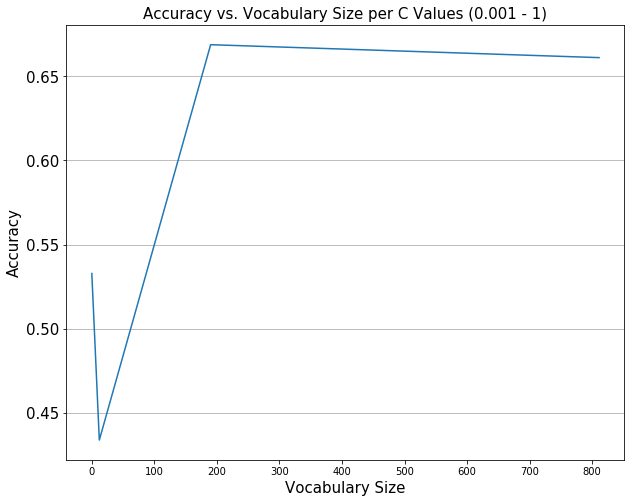

In [21]:
P6()

### Part 7:

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [22]:
def P7():
    """ P7 - Uses the TfidfVectorizer function then trains a logistic regression model with C = 100. Then, makes 
                predictions on the dev data and calculates each document's R ratio, which is the maximum predicted 
                probability divided by the predicted probability of the correct label. The three documents with the
                largest R ratio are then displayed.
    # param: None
    # return: None
    """
    
    #sets TfidfVectorizer and fits the training and dev data
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    #train and fit the LR model
    LRclf = LogisticRegression(penalty = 'l2', C = 100, solver='lbfgs', multi_class='auto', max_iter=1000)
    LRclf.fit(X, train_labels)
    
    #evaluate on the dev data
    LRy_pred = LRclf.predict(X_dev)
    
    #initialize variables
    all_R = []

    #iterate through each document in the dev data
    for i in range(0, len(LRclf.predict_proba(X_dev))):
        #get predicted probabilities
        my_probs = LRclf.predict_proba(X_dev)[i]

        #get max probability and the actual probability
        my_max = max(my_probs)
        my_actual = my_probs[dev_labels[i]]

        #compute R and append to list
        temp_R = my_max/my_actual
        all_R.append(temp_R)
     
    #iterate through the top 3
    for j in [1,2,3]:
        #get the index and the value for the largest R's
        large_R_index = np.argmax(all_R)
        large_R_value = all_R[large_R_index]

        #reset for next iteration
        all_R[large_R_index] = -1

        #get the message and the actual/predicted labels for the doc with large R
        R_message = dev_data[large_R_index]
        R_actual_label = dev_labels[large_R_index]
        R_predicted_label = LRy_pred[large_R_index]

        #map the actual label to its category
        if R_actual_label == 0:
            lab_type1 = 'alt.atheism'
        elif R_actual_label == 1:
            lab_type1 = 'comp.graphics'
        elif R_actual_label == 2:
            lab_type1 = 'sci.space'
        else:
            lab_type1 = 'talk.religion.misc'

        #map the predicted label to its category
        if R_predicted_label == 0:
            lab_type2 = 'alt.atheism'
        elif R_predicted_label == 1:
            lab_type2 = 'comp.graphics'
        elif R_predicted_label == 2:
            lab_type2 = 'sci.space'
        else:
            lab_type2 = 'talk.religion.misc'

        #print the messages and their labels
        print('Document with #', j, ' largest ratio R: ', R_message )
        print('\nActual Label: ', R_actual_label, ' & Actual Label Category: ', lab_type1)
        print('\nPredicted Label: ', R_predicted_label, ' & Actual Label Category: ', lab_type2)
        print('\nR: ', large_R_value)
        print('\n_________________________________________________________________________________________\n')


In [23]:
P7()

Document with # 1  largest ratio R:  Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Actual Label:  3  & Actual Label Category:  talk.religion.misc

Predicted Label:  1  & Actual Label Category:  comp.graphics

R:  736.1715870512901

_________________________________________________________________________________________

Document with # 2  largest ratio R:  I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the pre

ANSWER:

* How is TfidfVectorizer different from the CountVectorizer? 

TfidfVectorizer is different from CountVectorizer. CountVectorizer implements both tokenization and occurrence counting in a single class. However, as we have seen in previous Parts, some words will be very present (e.g. “the”, “a”, “is” in English) despite carrying very little meaningful information about the actual contents of the document. By just relying on count, those very frequent terms then shadow the frequencies of rarer yet more interesting terms. So, in order to re-weight the count features into values suitable for usage by a classifier, it is very common to use the tf–idf transform. The tfidf transformation calculates the term frequency, the number of times a term occurs in a given document, then  multiplies it with the idf component. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

* What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

There are a few mistakes that the model makes. 

The IDF component of TF*IDF can harm the classification accuracy in some cases. The inverse document frequency of a certain distinguishing word will be very low if it occurs frequently in a large training data set, across many documents. That feature would then get a very small TFIDF, which is the weight of the feature used by the classifier. This is an example where TFIDF may reduce the classification accuracy. So if there are more instances in one class, the good word features of the frequent class risk having lower IDF, thus their best features will have a lower weight due to class imbalance. 

It is then possible that words that occur frequently in one class can also appear frequently in a different class. This would increase the IDF score, which would then lower the weight of that feature for both classes. If those two classes were imbalanced in size, the bigger class will have other distinguishable features to help classify it. So, if one class that is very big shares a distinguishing feature with a class that is smaller, the smaller class will be harder to classify due to the tfidf weighting scheme. 

In this context, it seems as though the model has trouble distinguishing Class 3, the 'talk.religion.misc' category. Each of the documents with the top three highest R-scores should be labeled as Class 3. Yet, they are predicted to be something else. This could be because the 'misc' portion of the category makes it a very broad category and so the features are not representative enough to distinuish it from a different category. It could also be because Class 3 shares a religious subject with Class 0, 'alt.atheism'. 

As a result, a potential way to address this issue it to implement random oversampling for our training data. This would consist of determining the classes that have fewer documents in them. Then, additional copies of documents in that category would be added to the overall data set. This is essentially resampling with replacement. The method would help to normalize class imbalances and reduce the problems mentioned above. Another potential solution would be to preprocess and tokenize the data. These methods would normalize the input in various ways to improve generalization.

### Part 8 EXTRA CREDIT:

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

Based on my error analysis, I will apply resampling and preprocesing/tokenization to my data. Then, I will use the TfidfVectorizer function in order to transform my text data for my logistic regression model.

First, we will establish a basline model. This consists of unmanipulated data and no extra tuning of parameters.

##### Baseline:

In [24]:
#use the Pipeline to train a TfidfVectorizer and LogisticRegression model of the training and dev data 
pipeline = Pipeline([('tfidf',TfidfVectorizer()),
                     ('lr',LogisticRegression(penalty = 'l2', C = 100, solver='lbfgs', 
                                              multi_class='auto', max_iter=1000))])
pipeline.fit(train_data,train_labels)
pipe_pred = pipeline.predict(dev_data)

#print the F1 score for the model to serve as a baseline
print(metrics.f1_score(dev_labels, pipe_pred, average='weighted'))

0.7680092163691469


The baseline F1 score will be 0.76.

Next, we will apply the reampling method.

##### Resampling:

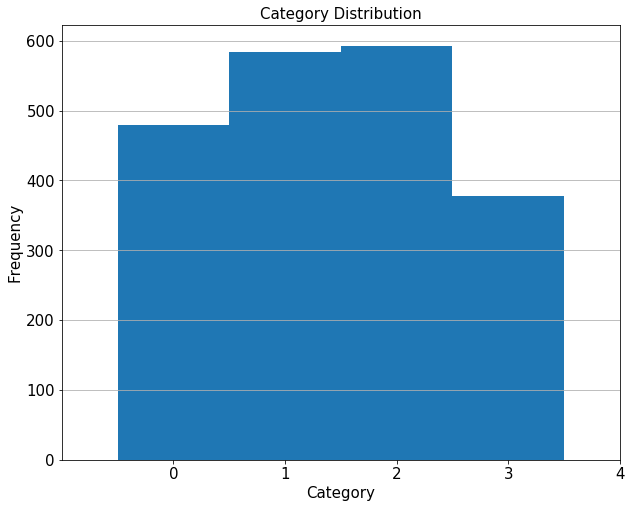

In [25]:
#plot the distribution of documents between the four topic categories
plt.figure(figsize=[10,8])
bins = np.arange(5) - 0.5
plt.hist(train_labels, bins)
plt.xlim(-1, 3.5)
plt.grid(axis='y')
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(range(5), fontsize=15)
plt.yticks(fontsize=15)
plt.title('Category Distribution',fontsize=15)
plt.show()

We can see that Category 0 and Category 3 are substantially smaller than Category 1 and Category 2. So, we will add more samples from Category 3 and 0, but more from 3 than 0. This will be done to help normalze the class imbalances and allow for greater category representation.

In [26]:
#initialize variables
cat0 = []
lab0 = []
cat1 = []
lab1 = []
cat2 = []
lab2 = []
cat3 = []
lab3 = []

#iterate through the training data
for i in range(0,len(train_data)):
    #get the docuemnt and labels
    my_doc = train_data[i]
    my_lab = train_labels[i]
    
    #separate the training data into respective categories
    if my_lab == 0:
        cat0.append(my_doc)
        lab0.append(0)
    elif my_lab == 1:
        cat1.append(my_doc)
        lab1.append(1)
    elif my_lab == 2:
        cat2.append(my_doc)
        lab2.append(2)
    else:
        cat3.append(my_doc)
        lab3.append(3)

In [54]:
#shuffle add the data to make the oversampling truely random
np.random.shuffle(cat0)
np.random.shuffle(cat1)
np.random.shuffle(cat2)
np.random.shuffle(cat3)

In [55]:
#create new copies of the training data
td_copy = train_data.copy()
tl_copy = train_labels.copy().tolist()

#add additional documents from the smaller categories to the training data
for i in range(0,225):
    td_copy.append(cat3[i])
    tl_copy.append(lab3[i])
    
    #add fewer documents from Category 0
    if i <= 75:
        td_copy.append(cat0[i])
        tl_copy.append(lab0[i])

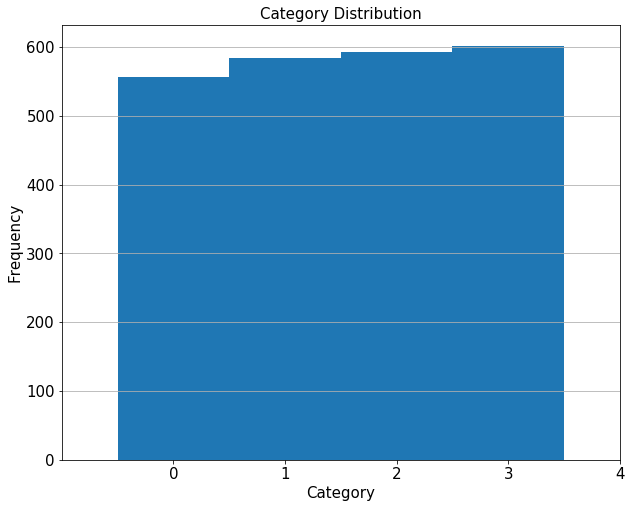

In [56]:
#plot the new distribution of documents between the four topic categories
plt.figure(figsize=[10,8])
bins = np.arange(5) - 0.5
plt.hist(tl_copy, bins)
plt.xlim(-1, 3.5)
plt.grid(axis='y')
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(range(5), fontsize=15)
plt.yticks(fontsize=15)
plt.title('Category Distribution',fontsize=15)
plt.show()

We can see that there is now a more even distribution of documents within each category. Although Category 3 now has the most documents in the data set, the classifer had the most difficulty with this topic so this will help to improve its representation.

In [57]:
#use the Pipeline to form the TfidfVectorizer and LogisticRegression functions
pipeline = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1, 2))),
                     ('lr',LogisticRegression(penalty = 'l2', C = 100, solver='lbfgs', 
                                              multi_class='auto', max_iter=1000))])

#fit the resampled data to the pipeline model
pipeline.fit(td_copy,tl_copy)

#get the predictions for the dev data
pipe_pred = pipeline.predict(dev_data)

#print the F1 score, for comparison
print(metrics.f1_score(dev_labels, pipe_pred, average='weighted'))

0.7743384137031204


The resampling (random oversampling) method did improve the F1-score to 0.77. This helped to reduce the class imbalances. Although it was only a small improvement, the resampling was very basic as it merely added more samles for the two topic categories that had fewer documents in the training data. A more extensive resampling could be applied in the future with functions in other libraries. Nonetheless, resampling helped to improve the model, using the TfidfVectorizer and LogisticRegression.

Last, we will try to tokenize and preprocess the data.

##### Tokenize & Preprocess:

In [31]:
def erin_preprocessor(s):
    """ erin_preprocessor - Takes a single training document as an input, performs multiple different manipulations
            in order to normalize the input and improve its generalization.
    # param: s - string input that represents a training document
    # return: s - string output that represents a changed training document
    """
    
    #lower the case of all words and remove special symbols
    new_str = s.lower()
    new_str = re.sub(r'[()?<>_,.":!;]', ' ', new_str)
    new_str = re.sub(r'!"#$%&()+,-./:;<=>@?\^_`{|}~', ' ', new_str)
    new_str = new_str.strip()
    new_str = new_str.replace('\n', ' ')
    new_str = new_str.replace('@', ' ')
    new_str = new_str.replace('*', ' ')
    new_str = new_str.replace('-', '')
    new_str = new_str.replace('%', '')
    new_str = new_str.replace('|', '')
    new_str = new_str.replace('}', '')
    new_str = new_str.replace('/', ' ')
    
    #replace numbers with a special symbol (*)
    new_str = re.sub(r'\d+', ' * ', new_str)
    
    s = new_str
    return s

In [32]:
def tokenize(text):
    """ tokenize - Takes a single training document as an input, performs tokenization and stemming on the string,
            then returns the list of manipulated words.
    # param: text - string input that represents a training document
    # return: stems - list output that represents a changed training document
    """
    
    #tokeninze the document
    tokens = nltk.word_tokenize(text)
    
    #initialize variables
    stems = []
    
    #iterate through each token
    for item in tokens:
        
        #stem the token
        stems.append(nltk.stem.porter.PorterStemmer().stem(item))
        
    #return the list of stemmed tokens
    return stems

In [33]:
#use the Pipeline to form the TfidfVectorizer and LogisticRegression functions
pipeline = Pipeline([('tfidf',TfidfVectorizer(tokenizer=tokenize, 
                        preprocessor=erin_preprocessor,
                        min_df=5, max_df=0.8,
                        ngram_range=(1, 2))),
                     ('lr',LogisticRegression(penalty = 'l2', C = 100, solver='lbfgs', 
                                              multi_class='auto', max_iter=1000))])

#fit the original data to the pipeline model with tokenization/preprocessing
pipeline.fit(train_data,train_labels)

#get the predictions for the dev data
pipe_pred = pipeline.predict(dev_data)

#print the F1 score, for comparison
print(metrics.f1_score(dev_labels, pipe_pred, average='weighted'))

0.7618028160113318


Tokenization and preprocessing did not necessarily improve the F1 score, but it did, at least, achieve the same score F1 score as the basline model with a score of 0.76. These techniques aim to improve the generalization of the vocabulary, yet its seems that resampling was more effective in improveing the F1 score for the model.